<hr style="height:2px;border:none"/>
<center>
    <h1>INF495 - Modelamiento Computacional Aplicado</h1>
    <h1> - Proyecto -</h1>
    <h2> Modelamiento de tráfico de bicicletas en dos pistas para análisis de accidentes </h2>
    <h3>José Quezada</h3>
</center>
<br>
<hr style="height:2px;border:none"/>

## Supuestos

- Se cuenta con 2 pistas contiguas, en distinto sentido vehicular, exclusivas para bicicletas.
- Hay un flujo de entrada constante de bicicletas a ambas pistas.
- Las bicicletas pueden contar con una de 3 velocidades máximas distintas, escogidas al azar.
- Se cuenta con una variable de atención, que define la aceleración de frenado de manera directamente proporcional.
- Cuando una bicicleta detecta otra delante suyo, su aceleración actual cambia a la de frenado, con tal de disminuir la velocidad e intentar no colisionar. En caso de haber frenado, se comprueba que no haya ningún otro individuo cercano en la otra pista y, de ser así, se cambia a esta, con tal de poder pasar a su "oponente". Luego se realiza la misma comprobación para regresar, una vez se superó al otro ciclista.

# Modelo de agente

### Representación espacial
El mapa consiste en dos pistas del mismo largo, cuyas unidades de distancia se basan en una densidad de "pixeles" por metro. (Se le llaman pixeles, por simplicidad, a cada elemento de la matriz que compone el mapa)  
En este caso se escogen **100 [px/m]**, y un largo de pista de **100 [m]** o **10.000 [px]**.

### Representación temporal
De la misma forma, se define una resolución para los time-steps (*Δt*), que consiste en el tiempo que transcurre en cada iteración, con tal de poder contar con una mejor especificidad al realizar cálculos y decisiones, como al frenar, y el criterio para que dos bicicletas colisionen.  

Como ejemplo, si la iteración dura 0.2 \[s], y la velocidad actual de una bicicleta son 5 \[m/s], sería equivalente a:  
$$ 5 [m/s] \cdot (0.2 [s] / 1 Δt) = 1 [m/Δt]  $$

### Atención
Se define además este atributo como una variable aleatoria, definida como una gaussiana truncada entre 0 y 1, con $\mu$ = 0.5 y $\sigma$ = 0.2. 

Esta representaría, de manera conceptual, el tiempo de reacción para que un ciclista comience a frenar. Sin embargo, para simplicidad del modelo, 

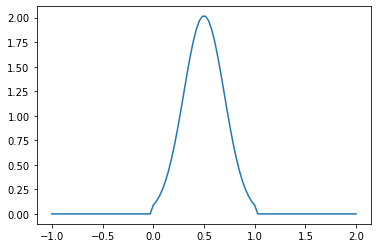

In [ ]:
x = np.linspace(-1,2,100)
plt.figure()
plt.plot(x, stats.truncnorm((0 - 0.5) / 0.2, (1 - 0.5) / 0.2, loc=0.5, scale=0.2).pdf(x))
plt.show()

### Estructura de mapeo
Se cuenta con una estructura de datos, que corresponde a dos hashings o diccionarios que guardan el identificador y la posición actual de cada bicicleta, asociando estos datos a un área específica de cada pista, así optimizando de mejor manera la búsqueda de vecinos, tanto para frenar en una pista como para decidir si cambiar a la otra.  

De esta manera se puede obtener la sección a la que una instancia de bicicleta pertenece, a partir de su posición en una de las pistas.   

Por ejemplo, si la posición corresponde a 15, en una pista con 4 secciones de tamaño 6, basta con realizar el siguiente cálculo:
$$\lfloor\frac{15}{6}\rfloor = 2$$  

Perteneciendo en este caso, la posición 15 a la tercera sección (i=2) del mapa.

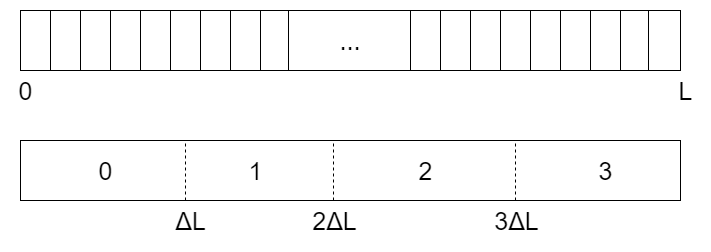

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import signal

In [ ]:
class bicicleta:
    def __init__(self, id, loc, vMax, acc, accFreno, orientacion):
        self.id = id
        self.loc = loc
        self.orientacion = orientacion
        
        # gaussiana truncada
        self.atencion = round(stats.truncnorm((0 - 0.5) / 0.2, (1 - 0.5) / 0.2, loc=0.5, scale=0.2).rvs(), 2)
        
        self.vAct = int(vMax/4)
        self.vMax = vMax
        
        self.initAcc = acc
        self.actAcc = acc
        
        self.accFreno = self.atencion * accFreno
        self.frenado = 0 # para indicar si ya frenó una vez

        self.oponenteId = -1 # id de bicicleta que se quiere evitar


class pista:
    def __init__(self, largo, ancho):
        self.largo = largo
        self.map = np.zeros((ancho, largo))

In [ ]:
# elimina un elemento de un arreglo de manera eficiente
# además elimina los datos del elemento del mapa y del hash de mapeo (Pm)
def swapop(Poblacion, index, Pista, Pm):
   
    coordMapaDead = Poblacion[index].loc
    coordMapaLast = Poblacion[-1].loc

    delta_L = Pista.largo/len(Pm)
    mappingDead = int(np.floor(coordMapaDead[1]/delta_L))
    if coordMapaDead[0] == 1:
        mappingDead = len(Pm) - 1 - mappingDead
    # mappingLast = int(np.floor(coordMapaLast[1]/delta_L))
    
    if debug:
        print("mapping: id:", Poblacion[index].id, "Pm[]:", Pm[mappingDead])
    
    Pm[mappingDead] = [m for m in Pm[mappingDead] if m[0] != Poblacion[index].id]
            
    # si el elemento a ser eliminado no es el último
    if index < len(Poblacion) and index != -1 and index >= 0:

        # guardar en aux datos del ciclista finalizado
        aux = Poblacion[index]
        Poblacion[index] = Poblacion[-1]
        Poblacion[-1] = aux
    
    elif index < 0:
        print("\n[swapop]: error: index menor a 0")
    
    # eliminar datos del mapa
    Pista.map[coordMapaDead[0], coordMapaDead[1]] = 0

    # eliminar último elemento de arreglo
    Poblacion.pop()


    return Poblacion, Pista, Pm


# transforma velocidad de Km/h a px/delta_t
def KmhToPxDt(vel, pxpm, delta_t):
    return int(vel * 1000 / 3600 * pxpm * delta_t)


# minima distancia (e indice dentro Area) de una bicicleta a otra en una pista específica
def getMinDist(Poblacion, Pm_p, mappingArea, pIndex, cambioPistaBool):

    # area de mapeo
    Area = Pm_p[mappingArea]
    if mappingArea != len(Pm_p) - 1:
        Area = Pm_p[mappingArea] + Pm_p[mappingArea + 1]

    minIndex = pIndex
    minDist = radioCerc
    oponenteId = -1

    if debug:
        print("area [getMinDist]:", Area)

    index = 0
    for bici in Area:
        
        idBici = bici[0]
        locBici = bici[1][1]

        if idBici != Poblacion[pIndex].id:
        
            if cambioPistaBool:
                dist = Poblacion[pIndex].orientacion * (locBici - Poblacion[pIndex].loc[1])
            else:
                dist = abs((locBici - Poblacion[pIndex].loc[1]))
            
            if dist >= 0 and dist < minDist:
                minDist = dist
                minIndex = index
                oponenteId = idBici
        
        index += 1

    return Area, minIndex, minDist, oponenteId


# retorna index: accidente, 1111: si, 9999: no
def bicicleta_cercana_mapping(Pista, Poblacion, pIndex, mappingArea, Pm_p):

    Area, minIndex, minDist, oponenteId = getMinDist(Poblacion, Pm_p, mappingArea, pIndex, False)

    if debug:
        print("minDist:", minDist)

    if minIndex != pIndex:
        
        # accidente
        if minDist < 2*pxpm:
            
            if debug:
                print("accidente!")

            loc = Poblacion[pIndex].loc

            Pista.map[loc[0], Area[minIndex][1][1]] = 0
            Pista.map[loc[0], loc[1]] = 0

            return Pista, minDist, oponenteId

        # solo hay que frenar (se está cerca, pero ni tanto)
        else:
            return Pista, 11111, oponenteId


    # no hay nadie cerca
    return Pista, 9999, -1


# cambiar a otra pista específica
def switchPista(Poblacion, Pista, Pm, pIndex, mappingArea, prev_loc, nuevaPista):

    prevPista = prev_loc[0]
    _, _, minDist, _ = getMinDist(Poblacion, Pm[nuevaPista], mappingArea, pIndex, True)

    if minDist >= radioCerc:

        if debug:
            print("cambio de pista, minDist:", minDist)
        
        
        # actualizar mapa
        Pista.map[prevPista, prev_loc[1]] = 0
        Pista.map[nuevaPista, prev_loc[1]] = 1
        
        # actualizar mapeo
        Pm[prevPista][mappingArea] = [m for m in Pm[prevPista][mappingArea] if m[0] != Poblacion[pIndex].id]
        mappingArea = len(Pm[0]) - mappingArea - 1
        Pm[nuevaPista][mappingArea].append([Poblacion[pIndex].id, Poblacion[pIndex].loc])

        return Pista, Pm, True

    else:
        return Pista, Pm, False


# regresar a pista original una vez se pasó al ciclista oponente
def returnToPista(Poblacion, Pista, Pm, largoPm, mappingArea, pIndex, prev_loc, pistaOriginal, vel):
    
    oponenteArea = largoPm - 1 - mappingArea

    if debug:
        print("oponenteArea inicial:", oponenteArea, "areaActual:", mappingArea)
    
    returnP = False
    oponenteFound = False
    i = 0
    while not oponenteFound:
        if oponenteArea >= largoPm:
            oponente_loc = -1
            if debug:
                print("oponente murió")
            break
        for i in Pm[pistaOriginal][oponenteArea]:
            if i[0] == Poblacion[pIndex].oponenteId:
                oponente_loc = i[1][1]
                oponenteFound = True
        oponenteArea += 1
    
    distOponente = Poblacion[pIndex].orientacion * (prev_loc[1] - (oponente_loc + vel))
    if  distOponente > 2*pxpm or oponente_loc == -1: # por mientras usaré la máxima velocidad
        Pista, Pm, switch = switchPista(Poblacion, Pista, Pm, pIndex, mappingArea, prev_loc, pistaOriginal)
        if debug:
            print("distancia a oponente:", Poblacion[pIndex].orientacion * (prev_loc[1] - (oponente_loc + vel)))
        if switch:
            returnP = True

    return Pista, Pm, returnP


In [ ]:
def main():

    # manejar ctrl + C
    def signal_handler(sig, frame):

        print("Total:", cantTotalFinal, "\nMeta:", cantMetaFinal, "\nAccidentados:", cantAccidentFinal, "\nAndando:", cantTotalFinal-cantMetaFinal-cantAccidentFinal)

        if not debugMap:
            modelEnd(t, delta_t, pobs, meta, accident, pobsFinal, metaFinal, accidentFinal, accidentPista, accidentFreno, otraPistaAct, Freno)
        sys.exit(0)
        
    signal.signal(signal.SIGINT, signal_handler)

    # inicializar pista
    largoP = pxpm * 100 # px/m * m | granularidad y distancia
    # 100 pixeles/metro -> 1 px/cm
    P = pista(largoP, 2)

    # hash con mapeo de ubicación de ciclistas en "largoPm" sectores
    # una para cada pista
    Pm = [{}, {}]
    largoPm = int(largoP / radioCerc)
    for l in range(largoPm):
        Pm[0][l] = []
        Pm[1][l] = []
        
    delta_L = P.largo/largoPm

    t = 0

    # población de bicicletas
    Pob = []


    cantTotalFinal = 0
    cantMetaFinal = 0
    cantAccidentFinal = 0
    
    cantAccidentPista = 0
    cantAccidentFreno = 0
    cantOtraPistaAct = 0
    cantFreno = 0

    # registro de estados de ciclistas
    pobs = []
    meta = []
    accident = []
    pobsFinal = []
    metaFinal = []
    accidentFinal = []

    accidentPista = []
    accidentFreno = []

    otraPistaAct = []
    Freno = []

    while t < T:

        cantTotal = 0
        cantMeta = 0
        cantAccident = 0

        # hacer variable
        # inicializar bicicleta
        if round(t, 1) % (flujo_in / delta_t) == 0:

            v1 = KmhToPxDt(8, pxpm, delta_t)
            v2 = KmhToPxDt(12, pxpm, delta_t)
            v3 = KmhToPxDt(20, pxpm, delta_t)

            initVMax = np.random.choice([v1, v2, v3], p= [0.3, 0.55, 0.15])

            # que en 4 pasos alcance la velocidad máxima
            initAcc = int(np.ceil(initVMax/4 / 1))

            # pista 0
            if np.random.random() < 0.5:

                initLoc = [0,0]
                initOrientacion = 1

            # pista 1
            else:
                initLoc = [1, largoP-1]
                initOrientacion = -1
                            
            Pob.append(bicicleta(cantTotalFinal + cantTotal, initLoc, initVMax, initAcc, accFreno, initOrientacion))  # aqui cantTotal sirve como id
            P.map[Pob[-1].loc[0], Pob[-1].loc[1]] = 1
            Pm[initLoc[0]][0].append([cantTotalFinal + cantTotal, initLoc])

            cantTotal += 1


        pobFin = []
        b_index = 0
        for _ in Pob:

            # si la bicicleta ya se encontró en un accidente
            if b_index in pobFin:
                b_index += 1
                continue

            # ubicación actual
            prev_loc = Pob[b_index].loc
            
            PmArea = int(np.floor(prev_loc[1]/delta_L))
            if prev_loc[0] == 1:
                PmArea = largoPm - 1 - PmArea # se invierte en la otra pista

            if debug:
                print("\nUbicación actual:", prev_loc, "Area:", PmArea)

            P, bc, oponenteId = bicicleta_cercana_mapping(P, Pob, b_index, PmArea, Pm[prev_loc[0]])

            # Accidente
            if bc <= radioCerc:
                
                # buscar en Pob por loc
                pobFin.append(b_index)
                cantAccident += 1
                
                # si se está en otra pista
                if prev_loc[0] == Pob[b_index].orientacion or prev_loc[0] - 1 == Pob[b_index].orientacion:
                    cantAccidentPista += 1
                else:
                    cantAccidentFreno += 1

                index = 0
                while Pob[index].id != oponenteId:
                    index += 1

                pobFin.append(index)
                cantAccident += 1

                # bicicletas afectadas
                if debug:
                    print("accidentados:\n", b_index)
                    print(index)

                b_index += 1
                continue

            # Frenar (bicicleta cercana)
            elif bc == 11111:

                # cambiar pista
                if Pob[b_index].frenado == 2:

                    Pob[b_index].oponenteId = oponenteId

                    nuevaPista = abs(prev_loc[0] - 1)
                    
                    P, Pm, switch = switchPista(Pob, P, Pm, b_index, PmArea, prev_loc, nuevaPista)
                    
                    if switch:
                        Pob[b_index].loc[0] = nuevaPista
                        Pob[b_index].frenado = 0
                        PmArea = largoPm - 1 - PmArea
                        cantFreno -= 1
                        cantOtraPistaAct += 1

                else:
                    Pob[b_index].actAcc = accFreno
                    Pob[b_index].frenado = 1
                    if debug:
                        print("iniciar frenado")
                        print("actAcc:", Pob[b_index].actAcc)
                        print("initAcc:", Pob[b_index].initAcc)

                    cantFreno += 1
                    

            # Dejar de frenar (no hay bicicletas cercanas)
            elif bc == 9999 and Pob[b_index].actAcc == accFreno:
                Pob[b_index].actAcc = Pob[b_index].initAcc
                if debug:
                    print("nadie cerca, nueva acc:", Pob[b_index].initAcc)
                Pob[b_index].frenado = 0


            # volver a la pista original
            # no tienen que intentar volver de inmediato
            # pista 0 corresponde a orientación 1, así que si estás en la pista 1, es porque debes volver ;)
            if prev_loc[0] == Pob[b_index].orientacion:
                
                P, Pm, returnP = returnToPista(Pob, P, Pm, largoPm, PmArea, b_index, prev_loc, 0, v3)
                if returnP:
                    Pob[b_index].loc[0] = 0
                    Pob[b_index].frenado = 0
                    PmArea = largoPm - 1 - PmArea
                    cantOtraPistaAct -= 1
                    if debug:
                        print("cambio a pista original 0")

            # retorno a pista 1
            elif prev_loc[0] - 1 == Pob[b_index].orientacion:
                P, Pm, returnP = returnToPista(Pob, P, Pm, largoPm, PmArea, b_index, prev_loc, 1, v3)
                if returnP:
                    Pob[b_index].loc[0] = 1
                    Pob[b_index].frenado = 0
                    PmArea = largoPm - 1 - PmArea
                    cantOtraPistaAct -= 1
                    if debug:
                        print("cambio a pista original 1")


            # borrar posición previa en mapa
            P.map[prev_loc[0], int(prev_loc[1])] = 0


            # actualizar velocidad con aceleración actual (independiente de la situación)
            vAct = Pob[b_index].vAct
            actAcc = Pob[b_index].actAcc
            
            if vAct < Pob[b_index].vMax and vAct + actAcc >= 0:
                Pob[b_index].vAct += actAcc * 1
            
            # se detiene
            elif vAct + actAcc < 0:
                if debug:
                    print("frenado")
                Pob[b_index].vAct = 0
                Pob[b_index].frenado = 2


            # nueva ubicación
            new_loc = Pob[b_index].loc[1] + Pob[b_index].orientacion * int(Pob[b_index].vAct)
            
                
            # Meta
            if (Pob[b_index].loc[0] == 0 and new_loc >= P.largo) or (Pob[b_index].loc[0] == 1 and new_loc <= 0):
                pobFin.append(b_index)
                cantMeta += 1
                b_index += 1
                continue

            # Meta falsa (debería considerarse como accidente) (cuando se finaliza en otra pista)
            if (Pob[b_index].loc[0] - 1 == Pob[b_index].orientacion and new_loc < 0) or  \
               (Pob[b_index].loc[0] == Pob[b_index].orientacion and new_loc > P.largo):

                pobFin.append(b_index)
                cantAccident += 1
                b_index += 1
                continue

            # continuar recorrido
            else:

                Pob[b_index].loc = [Pob[b_index].loc[0], new_loc]
                
                nuevaArea = int(np.floor(new_loc/delta_L))
                if Pob[b_index].loc[0] == 1:
                    nuevaArea = largoPm - 1 - nuevaArea
                if debug:
                    print("nuevaArea:", nuevaArea, Pm[Pob[b_index].loc[0]][nuevaArea])
                
                # mover de area de mapeo
                if nuevaArea != PmArea:
                    Pm[Pob[b_index].loc[0]][PmArea] = [m for m in Pm[Pob[b_index].loc[0]][PmArea] if m[0] != Pob[b_index].id]
                    Pm[Pob[b_index].loc[0]][nuevaArea].append([Pob[b_index].id, Pob[b_index].loc])

                try:
                    index = 0
                    while Pm[Pob[b_index].loc[0]][nuevaArea][index][0] != Pob[b_index].id:
                        index += 1
                except:
                    sys.exit("Bicicleta no se encontró en su área de mapeo correspondiente.")
                
                Pm[Pob[b_index].loc[0]][nuevaArea][index][1][1] = new_loc
                

            # actualizar mapa
            P.map[Pob[b_index].loc[0], int(Pob[b_index].loc[1])] = 1

            b_index += 1


        # Eliminar bicicletas que llegaron a Meta y que se accidentaron
        pobFin = list(set(pobFin))
        pobFin.sort()
        if debug and len(pobFin) > 0:
            print("pobFin:", t, pobFin)
        for pf in reversed(pobFin):
            pistaAct = Pob[pf].loc[0]
            Pob, P, Pm[pistaAct] = swapop(Pob, pf, P, Pm[pistaAct])


        # visualización
        if debugMap:
            Y, X = np.where(P.map)

            fig, ax = plt.subplots(figsize=(12, 4))
            ax.plot(X,Y, ".")
            plt.xlim([0, P.largo])
            plt.ylim([-4.5, 5.5])
            ax.set_yticklabels([])

            plt.xlabel('Distancia [px] (1 [m] = 100 [px])')

            plt.show()
            plt.pause(0.05)
            clear_output(wait=True)

        t += delta_t

        cantTotalFinal += cantTotal
        cantMetaFinal += cantMeta
        cantAccidentFinal += cantAccident

        pobs.append(cantTotal)
        meta.append(cantMeta)
        accident.append(cantAccident)

        pobsFinal.append(cantTotalFinal)
        metaFinal.append(cantMetaFinal)
        accidentFinal.append(cantAccidentFinal)

        accidentPista.append(cantAccidentPista)
        accidentFreno.append(cantAccidentFreno)
        otraPistaAct.append(cantOtraPistaAct)
        Freno.append(cantFreno)

    # graficar datos
    if not debugMap:
        modelEnd(t, delta_t, pobs, meta, accident, pobsFinal, metaFinal, accidentFinal, accidentPista, accidentFreno, otraPistaAct, Freno)
    print("Total:", cantTotalFinal, "\nMeta:", cantMetaFinal, "\nAccidentados:", cantAccidentFinal, "\nAndando:", cantTotalFinal-cantMetaFinal-cantAccidentFinal)


In [ ]:
def plotData(delta_t, pobs, meta, accident, pobsFinal, metaFinal, accidentFinal, accidentPista, accidentFreno, otraPistaAct, Freno):

    pobs_count = len(pobs) - 1
    x = np.linspace(0, pobs_count, pobs_count + 1)
    
    plt.figure(figsize=(12,10))
    plt.title("Cantidades de ciclistas")
    # plt.plot(x, pobs, 'b.', label='Total')
    plt.plot(x, metaFinal, 'g.', label='Meta')
    plt.plot(x, accidentFinal, 'r.', label='Accidentados')
    plt.plot(x, np.array(pobsFinal)-np.array(metaFinal)-np.array(accidentFinal), '.', color="gold", label='Andando')
    
    plt.plot(x, accidentPista, '.', color='indigo', label='Accidentes en otra pista')
    plt.plot(x, accidentFreno, '.', color='hotpink', label='Accidentes con freno')
    plt.plot(x, otraPistaAct, '.', color='royalblue' ,label='En otra pista')
    plt.plot(x, Freno, '.', color='lawngreen', label='Freno')

    plt.legend(loc='best')
    plt.xlabel('Tiempo [Δt] (Δt = 0.1 [s])')
    plt.ylabel('Población')
    plt.grid(True)
    plt.show()


# función a ejecutar al terminar la simulación
def modelEnd(t, delta_t, pobs, meta, accident, pobsFinal, metaFinal, accidentFinal, accidentPista, accidentFreno, otraPistaAct, Freno):
    
    plotData(delta_t, pobs, meta, accident, pobsFinal, metaFinal, accidentFinal, accidentPista, accidentFreno, otraPistaAct, Freno)

## Visualización gráfica

In [ ]:
# np.random.seed(8)
np.random.seed(20)


flujo_in = 0.1

pxpm = 100 # px por mt (granularidad espacial)
delta_t = 0.1 # granularidad temporal
# tengo que aumentar esto para ver una animación más fluida y que los cálculos sean más precisos
T = 50

accFreno = -50 * pxpm * delta_t**2 #m/s^2 * px/m * s^2/delta_t^2-> px/delta_t^2 
radioCerc = 4 * pxpm

debug = False
debugMap = True

main()

Total: 26 
Meta: 3 
Accidentados: 10 
Andando: 13


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Gráficos

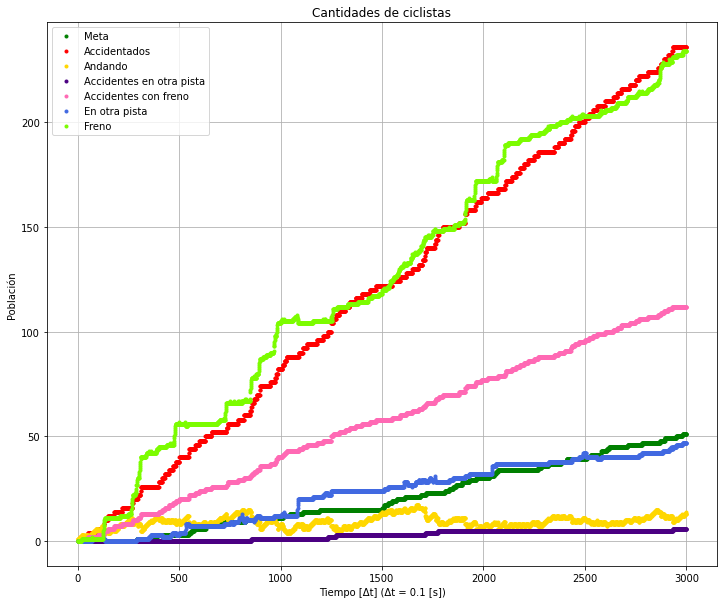

Total: 301 
Meta: 51 
Accidentados: 236 
Andando: 14


In [ ]:
T = 300
debug = False
debugMap = False

main()

# Modelo de compartimiento

Si bien, se considera un caso ideal como el que se presenta a continuación, debido a la complejidad y tiempo disponible, se propone un modelo simplificado.

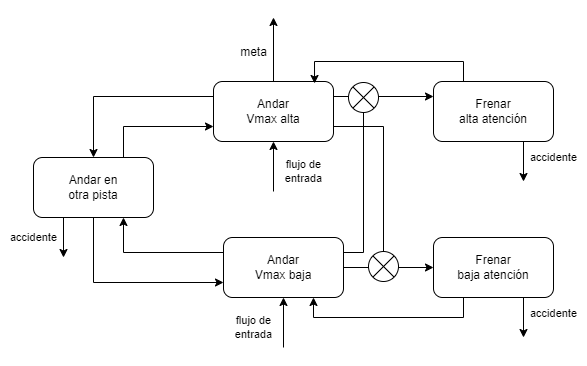

Con tal de poder buscar una solución de manera práctica, se propone el siguiente modelo en reemplazo del anterior.

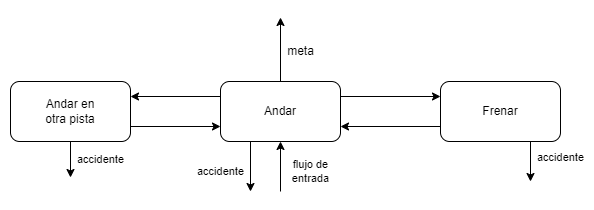

### Compartimientos
$B_{an}(t)$: Bicicletas andando  
$B_{f}(t)$: Bicicletas frenando  
$B_{p}(t)$: Bicicletas en otra pista

### Flujos
$\alpha$: Entrada  
$\pi_1$: Cambiar de pista  
$\pi_2$: Volver a pista original  
$\phi_1$: Comenzar a frenar  
$\phi_2$: Dejar de frenar  
$\gamma$: Meta  
$\beta_1$: Bicicletas colisionadas  
$\beta_2$: Accidentes en otra pista  
$\beta_3$: Accidentes al frenar

$$B_{an}'(t) = \alpha + \pi_2 B_p(t) + \phi_2 B_f(t) - \pi_1 B_{an}(t)-\phi_1 B_{an}(t) - \gamma B_{an}(t) - \beta_1 B_{an}(t) $$
$$B_{an}'(t) = \alpha + \pi_2 B_p(t) + \phi_2 B_f(t) - (\pi_1 +\phi_1 + \gamma + \beta_1) B_{an} (t) $$

</br>  
$$B_f'(t) = \phi_1 B_{an}(t) - \phi_2 B_{f}(t) - \beta_3 B_{f}(t) $$

</br>
$$B_p'(t) = \pi_1 B_{an}(t) - \pi_2 B_{p}(t) - \beta_2 B_{p}(t)$$


In [ ]:
# entrada
alpha = 0.1
# pista
pi_1 = 0.4
pi_2 = 0.8*pi_1 # es menos probable volver que cambiar
# freno
phi_1 = 0.8
phi_2 = 0.6
# meta
gamma = 0.2
# accidentes
beta_2 = 0.15
beta_3 = 0.1
beta_1 = pi_1 * beta_2 + phi_1 * beta_3 # los accidentes andando son solo producidos por las demás bicicletas chocándoles

In [ ]:
from scipy import integrate

In [ ]:
# diferencial
def d_y(t, y, alpha, pi_1, pi_2, phi_1, phi_2, gamma, beta_1, beta_2, beta_3):
    y1 = y[0] # B_an
    y2 = y[1] # B_f
    y3 = y[2] # B_p
    y4 = y[3] # Meta
    y5 = y[4] # Accidentados por frenar
    y6 = y[5] # Accidentados en otra pista
    
    return np.array([alpha + pi_2 * y3 + phi_2 * y2 - (phi_1 + phi_1 + gamma + beta_1) * y1,
                     phi_1 * y1 - (phi_2 * + beta_3) * y2,
                     pi_1 * y1 - (pi_2 + beta_2) * y3,
                     gamma * y1,
                     beta_3 * y2,
                     beta_2 * y3])

In [ ]:
#graficar modelo de compartimiento
def grafCompartimiento(t):

    x = np.linspace(0, t, t + 1)
    
    # valores iniciales
    y0 = np.array([alpha, 0, 0, 0, 0, 0])
    
    sol = integrate.solve_ivp(d_y, [0,t], y0, t_eval=x, args=(alpha, pi_1, pi_2, phi_1, phi_2, gamma, beta_1, beta_2, beta_3))
    
    # por si acaso
    ylen = len(sol.y[0])
    
    plt.figure(figsize=(10,12))
    plt.title("Modelo de compartimiento")
    plt.plot(x[0:ylen], sol.y[0], '.', color="gold", label='Bicicletas andando')
    plt.plot(x[0:ylen], sol.y[1], '.', color="lawngreen", label='Bicicletas frenando')
    plt.plot(x[0:ylen], sol.y[2], '.', color="royalblue", label='Bicicletas en otra pista')
    plt.plot(x[0:ylen], sol.y[3], 'g.', label='Meta')
    plt.plot(x[0:ylen], sol.y[4], '.', color="hotpink", label='Accidentes por frenar')
    plt.plot(x[0:ylen], sol.y[5], '.', color="indigo", label='Accidentes en otra pista')

    plt.legend(loc='best')
    plt.xlabel('t [s]')
    plt.ylabel('Población')
    plt.grid(True)
    plt.show()

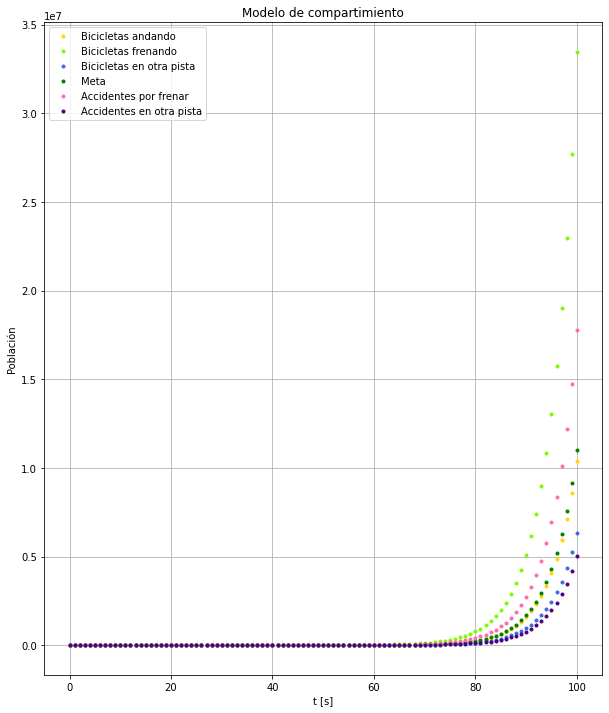

In [ ]:
grafCompartimiento(100)